<h1>Proposed Model</h1>

<h2>Variables</h2>

In [2]:
# Directory containing the dataset
dataset_dir = './12K-Sorted'

# Label map
label_map = {
    'Block': 0,
    'Interjection': 1,
    'NoStutter': 2,
    'Prolongation': 3,
    'SoundRepetition': 4,
    'WordRepetition': 5
}

# Reversed Label map
reversed_map = {v: k for k, v in label_map.items()}

# Preprocessing
duration = 3.0  # seconds
sampling_rate = 16000  # Hz
n_mels = 128
n_mfcc = 13

<h2>Retrieving audio files and their labels</h2>

In [3]:
import os

def get_audio_files_and_labels(dataset_dir):
    audio_files = []
    for label_dir in os.listdir(dataset_dir):
        if label_dir in label_map:
            label = label_map[label_dir]
            class_dir = os.path.join(dataset_dir, label_dir)
            for audio_file in os.listdir(class_dir):
                audio_path = os.path.join(class_dir, audio_file)
                audio_files.append((audio_path, label))
    return audio_files

<h2>Preprocessing</h2>

In [4]:
import librosa
import numpy as np

def preprocess_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=sampling_rate)

        if len(audio) != int(duration * sampling_rate):
            print(f"Audio file {audio_path} is not exactly {duration} seconds.")
            return None, None

        # Log-Mel Spectrogram
        log_mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(log_mel_spectrogram, ref=np.max)

        # MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        return log_mel_spectrogram.T, mfcc.T  # (time_steps, features)
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None, None

<h3>Preprocessing (single file)</h3>

In [5]:
def preprocess_concat_audio(audio_path, sr=sampling_rate):
    try:
        audio, _ = librosa.load(audio_path, sr=sr)

        if len(audio) != int(duration * sampling_rate):
            print(f"Audio file {audio_path} is not exactly {duration} seconds.")
            return None
        
        log_mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(log_mel_spectrogram, ref=np.max)

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        return np.concatenate((log_mel_spectrogram.T, mfcc.T), axis=-1)
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None

<h2>Load and preprocess dataset</h2>

In [6]:
def load_and_preprocess_dataset(audio_files):
    x = []
    y = []

    for audio_path, label in audio_files:
        log_mel, mfcc = preprocess_audio(audio_path)
        if log_mel is not None and mfcc is not None:
            combined_features = np.concatenate((log_mel, mfcc), axis=-1) # (time_steps, log_mel_features + mfcc_features)
            x.append(combined_features)
            y.append(label)

    x = np.array(x) # (batch, timesteps, features)
    y = np.array(y) # labels

    return x, y

<h2>Probability Distribution Plotting</h2>

In [7]:
import matplotlib.pyplot as plt

def plot_probability_distribution(probability_distribution):
    class_labels = [reversed_map[i] for i in range(len(probability_distribution))]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, probability_distribution, color='skyblue')
    plt.xlabel('Stutter Types')
    plt.ylabel('Probability')
    plt.title('Probability Distribution for Each Stutter Type')
    plt.show()

<h2>Layer Normalization</h2>

In [8]:
import torch
import torch.nn as nn
import math

class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))

    def forward(self, x):
        alpha = self.alpha.to(x.device)
        bias = self.bias.to(x.device)

        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return alpha * (x - mean) / (std + self.eps) + bias

<h2>2 x Conv1D Layer</h2>

In [9]:
import torch
import torch.nn as nn
import math

class Conv1DBlock(nn.Module):
    def __init__(self, feature_size: int, output_size: int, kernel_size: int, dropout: float) -> None:
        super().__init__()
        # First Conv1D Layer
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=feature_size*2, kernel_size=kernel_size, padding='same')
        self.norm = nn.LayerNorm(feature_size*2)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)

        # Second Conv1D Layer
        self.conv2 = nn.Conv1d(in_channels=feature_size*2, out_channels=output_size, kernel_size=kernel_size, padding='same')
        self.norm2 = nn.LayerNorm(output_size)
        
    def forward(self, x):
        # Conv1D -> LayerNorm -> GELU -> Dropout
        x = self.conv1(x.transpose(1, 2))  # Conv1D expects (batch, features, timesteps), so transpose
        x = self.norm(x.transpose(1, 2))  # LayerNorm expects (batch, timesteps, features), so transpose back
        x = self.activation(x)
        x = self.dropout(x)

        # Repeat for second Conv1D layer
        x = self.conv2(x.transpose(1, 2))
        x = self.norm2(x.transpose(1, 2))
        x = self.activation(x)
        return self.dropout(x)

<h2>Sinusoidal Positional Encoding</h2>

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, timesteps: int, d_model: int, dropout: float) -> None:
        super().__init__()
        self.timesteps = timesteps
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        # Create a matrix of shape (timesteps, d_model)
        pe = torch.zeros(timesteps, d_model)
        # Create a vector of shape (timesteps, 1)
        position = torch.arange(0, timesteps, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(1000.0) / d_model))
        # Apply the sin to even positions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # (1, timesteps, d_model)

        # Register as buffer so that the tensor will be saved to the file but not as a learned params
        self.register_buffer('pe', pe)

    def forward(self, x):
        # self.pe = self.pe.to(x.device)  
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

<h2>Feed Forward Neural Network</h2>

In [13]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 and B1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 and B2

    def forward(self, x):
        # (batch, timesteps, d_model) --> (batch, timesteps, d_ff) --> (batch, timesteps, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

<h2>Multi-head Self Attention Layer</h2>

In [14]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, f"d_model {d_model} is not divisible by h"
        
        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model) #Wq
        self.w_k = nn.Linear(d_model, d_model) #Wk
        self.w_v = nn.Linear(d_model, d_model) #Wv

        self.w_o = nn.Linear(d_model, d_model) #Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]

        # (batch, h, timesteps, d_k) --> (batch, h, timesteps, timesteps)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1) # (batch, h, timesteps, timesteps)
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, timesteps, d_model) --> (batch, timesteps, d_model)
        key = self.w_k(k) # (batch, timesteps, d_model) --> (batch, timesteps, d_model)
        value = self.w_v(v) # (batch, timesteps, d_model) --> (batch, timesteps, d_model)

        # (batch, timesteps, d_model) --> (batch, timesteps, h, d_k) --> (batch, h, timesteps, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # (batch, h, timesteps, d_k) --> (batch, timesteps, h, d_k) --> (batch, timesteps, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # (batch, timesteps, d_model) --> (batch, timesteps, d_model)
        return self.w_o(x)

<h2>Residual Connection</h2>

In [15]:
class ResidualConnection(nn.Module):
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

<h2>Encoder</h2>

In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_foward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])
    
    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_foward_block)
        return x
    
class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

<h2>Decoder</h2>

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(ResidualConnection(features, dropout) for _ in range(3))

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.self_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x
    
class Decoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

<h2>Classification Layer</h2>

In [18]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model: int, num_classes: int) -> None:
        super().__init__()
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # Take the mean of the encoder outputs over the sequence dimension
        x = x.mean(dim=1)
        return self.fc(x)

<h2>Transformer Model</h2>

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, encoder: Encoder, pos_enc: PositionalEncoding, classifier: ClassificationHead) -> None:
        super().__init__()
        self.encoder = encoder
        self.pos_enc = pos_enc
        self.classifier = classifier

    def encode(self, inputs, mask=None):
        x = self.pos_enc(inputs)
        return self.encoder(x, mask)
    
    def classify(self, x):
        return self.classifier(x)

<h2>12-Layer Encoder with an Alternate Freeze-Unfreeze Strategy</h2>

In [20]:
class StutterClassificationModel(nn.Module):
    def __init__(self, conv_block: Conv1DBlock, pos_enc: PositionalEncoding, encoder: Encoder, classifier: ClassificationHead):
        super().__init__()
        self.conv_block = conv_block
        self.pos_enc = pos_enc
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.conv_block(x)  # Output shape: (batch, timesteps, features)

        x = self.pos_enc(x)

        x = self.encoder(x, mask=None)

        return self.classifier(x)

In [21]:
def build_stutter_classification_model(input_dim: int, output_size: int, timesteps: int, num_classes: int, num_heads: int, num_layers: int, kernel_size: int, dropout: float) -> StutterClassificationModel:
    # Conv1D block
    conv_block = Conv1DBlock(input_dim, output_size, kernel_size, dropout)

    # Positional Encoding
    pos_enc = PositionalEncoding(timesteps, output_size, dropout)

    # Encoder
    encoder_layers = []
    for _ in range(num_layers):
        encoder_self_attention_block = MultiHeadAttentionBlock(output_size, num_heads, dropout)
        feed_forward_block = FeedForwardBlock(output_size, output_size * 4, dropout)
        encoder_layer = EncoderBlock(output_size, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_layers.append(encoder_layer)
    encoder = Encoder(output_size, nn.ModuleList(encoder_layers))

    # Freeze specific encoder blocks: 1st, 2nd, 3rd, 7th, 8th, and 9th layers
    freezed_layers = [0, 1, 2, 6, 7, 8]
    for i in freezed_layers:
        for param in encoder.layers[i].parameters():
            param.requires_grad = False

    # Classifier
    classifier = ClassificationHead(output_size, num_classes)
    
    # Create the StutterClassificationModel
    model = StutterClassificationModel(conv_block, pos_enc, encoder, classifier)
    
    # Initialize the parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return model

In [22]:
def get_model(config, input_dim, timesteps):
    model = build_stutter_classification_model(
        input_dim=input_dim,
        output_size=config['output_size'],
        timesteps=timesteps,
        num_classes=config['num_classes'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout']
    )
    return model

<h2>Model Inference Function</h2>

In [23]:
from tqdm import tqdm

def validate_model(model, val_loader, loss_fn, device, writer, global_step):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation for validation
        batch_iterator = tqdm(val_loader, desc="Validating")
        for batch in batch_iterator:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted_labels = torch.max(outputs, 1) 
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

            batch_iterator.set_postfix({
                "val_loss": f"{loss.item():6.3f}", 
                "accuracy": f"{(correct_predictions / total_predictions):6.3f}"
            })

    # Calculate the average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('val loss', avg_val_loss, global_step)
    writer.add_scalar('val accuracy', accuracy, global_step)
    writer.flush()

    return avg_val_loss, accuracy

<h2>Model Prediction Function</h2>

In [24]:
import torch.nn.functional as F

def predict(model, input):
    model.eval()

    with torch.no_grad():
        output = model(input)

    probabilities = F.softmax(output, dim=1)

    predicted_class = torch.argmax(probabilities, dim=1).item()
    probability_distribution = probabilities.squeeze().cpu().numpy()

    return predicted_class, probability_distribution

<h1>Main Training-Validation Loop Function</h1>

In [42]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from config import get_config, get_weights_file_path, latest_weights_file_path
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils import class_weight

def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device {device}")
    if (device == "cuda"):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    device = torch.device(device)

    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    audio_files = get_audio_files_and_labels(dataset_dir)
    x, y = load_and_preprocess_dataset(audio_files)

    # Train/Test split
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    x_val = torch.from_numpy(x_val).float()
    y_train = torch.from_numpy(np.array(y_train)).long()
    y_val = torch.from_numpy(np.array(y_val)).long()

    # Move the tensors to device specified
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    
    # Create Dataset and DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    train_loader = DataLoader(train_dataset, config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    input_shape = x_train.shape[-1]
    timesteps = x_train.shape[1]

    model = get_model(config, input_shape, timesteps).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['lr'])

    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    y_train_cpu = y_train.to("cpu")

    y_train_np = y_train_cpu.numpy()

    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train_np),
        y=y_train_np
    )

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights_tensor).to(device)

    for epoch in range(initial_epoch, config['epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_loader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            inputs = batch[0].to(device) 
            labels = batch[1].to(device) 

            outputs = model(inputs)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(outputs, labels)
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        validate_model(model, val_loader, loss_fn, device, writer, global_step)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            model_filename = get_weights_file_path(config, f"{epoch:02d}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'global_step': global_step
            }, model_filename)

<h2>Model Training</h2>

In [ ]:
import warnings

warnings.filterwarnings("ignore")
config = get_config()
train_model(config)

<h2>Model Prediction</h2>

Preloading model models/68acc_0_512_12_8/convtmodel_29.pt
Audio File: ./12K-Sorted\NoStutter\StutterTalk_26_42.wav
Actual Label: NoStutter
Predicted Class: NoStutter
Probability Distribution: [0.13550869 0.3367088  0.3530492  0.06590346 0.03062885 0.07820106]
2


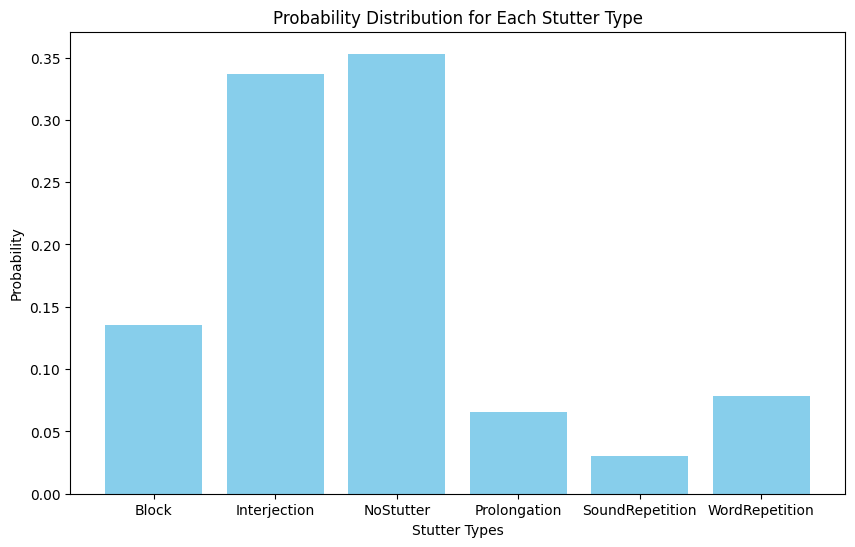

In [55]:
from config import get_config
config = get_config()

audio_files = get_audio_files_and_labels(dataset_dir)

audio, label = audio_files[6666]

input = preprocess_concat_audio(audio)

input = torch.from_numpy(input).float()
input = input.unsqueeze(0)

input_shape = input.shape[-1]
timesteps = input.shape[1]

model = get_model(config, input_shape, timesteps)

saved_model = 'models/68acc_0_512_12_8/convtmodel_29.pt'

print(f'Preloading model {saved_model}')
print(f"Audio File: {audio}")
state = torch.load(saved_model)
model.load_state_dict(state['model_state_dict'])

predicted_class, probabilities = predict(model, input)

print(f"Actual Label: {reversed_map.get(label)}")
print(f"Predicted Class: {reversed_map.get(predicted_class)}")
print(f"Probability Distribution: {probabilities}")

print(predicted_class)

plot_probability_distribution(probabilities)